In [37]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time

In [38]:
data = pd.read_csv("heart_2020_cleaned.csv")

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [39]:
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [13]:
data.shape

(319795, 18)

In [14]:
data.replace("Yes", 1, inplace = True)
data.replace("No", 0, inplace = True)
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,Female,55-59,White,1,1,Very good,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,Female,80 or older,White,0,1,Very good,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,Male,65-69,White,1,1,Fair,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,Female,75-79,White,0,0,Good,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,Female,40-44,White,0,1,Very good,8.0,0,0,0


In [15]:
data['Diabetic'].unique()

array([1, 0, 'No, borderline diabetes', 'Yes (during pregnancy)'],
      dtype=object)

In [16]:
data.replace("Yes (during pregnancy)", 1, inplace = True)
data.replace("No, borderline diabetes", 0, inplace = True)

In [17]:
data["Sex"].unique()

array(['Female', 'Male'], dtype=object)

In [18]:
data.replace("Female", 1, inplace = True)
data.replace("Male", 0, inplace = True)

In [2]:
#...Distribution of continuous variables...#

In [3]:
#...Distribution of categorical variables...#

In [4]:
#...Association of the response with the predictors...#

### Data cleaning
*By Xena Valenzuela*

From the data quality check we realized that:

1. Some of the columns that should have contained only numeric values, specifically <>, <>, and <> have special characters such as \*, #, %. We'll remove these characters, and convert the datatype of these columns to numeric.

2. Some of the columns have more than 60% missing values, and it is very difficult to impute their values, as the values seem to be missing at random with negligible association with other predictors. We'll remove such columns from the data.

3. The column `number_of_bedrooms` has some unreasonably high values such as 15. As our data consist of single-family homes in Evanston, we suspect that any value greater than 5 may be incorrect. We'll replace all values that are greater than 5 with an estimate obtained using the $K$-nearest neighbor approach.

4. The columns `house_price` has some unreasonably high values. We'll tag all values greater than 1 billion dollars as "potentially incorrect observation", to see if they distort our prediction / inference later on.

The code below implements the above cleaning.

In [5]:
#...Code with comments...#

In [35]:
# Replace columns with error characters "-", "/" or " " to prepare for forward selection

def makeDummies(data):
    data = pd.concat([data, pd.get_dummies(data['Race'])], axis=1)
    data = pd.concat([data, pd.get_dummies(data['AgeCategory'])], axis=1)
    data = pd.concat([data, pd.get_dummies(data['GenHealth'])], axis=1)
    #remove last category to avoid multicollinearity
    data = data.drop(columns=['Race', 'Other','AgeCategory','80 or older', 'GenHealth', "Excellent"])
    data.rename(columns={"18-24": "Age1", "25-29": "Age2", "30-34": "Age3","35-39": "Age4","40-44": "Age5","45-49": "Age6","50-54": "Age7","55-59": "Age8","60-64": "Age9","65-69": "Age10","70-74": "Age11","75-79": "Age12"}, inplace = True)
    data.rename(columns={"Very good": "Verygood", "American Indian/Alaskan Native": "AmericanIndianAlaskanNative"}, inplace = True)
    return data

### Data preparation
*By Sankaranarayanan Balasubramanian and Chun-Li*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have shuffled the dataset to prepare it for K-fold cross validation.

3. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [7]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

In [8]:
######-----------Shuffling the dataset for K-fold------------#########

In [9]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis


Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

<AxesSubplot:>

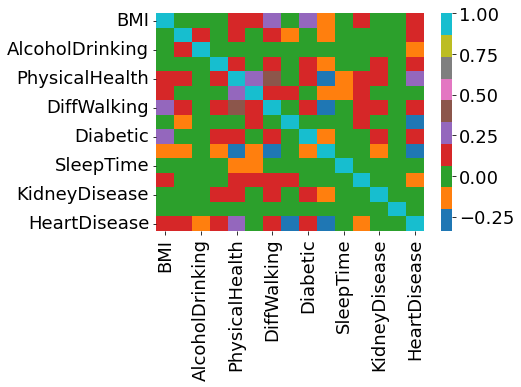

In [73]:
sns.heatmap(train_smote.corr(), cmap='tab10')

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Forward Stepwise Selection 

*by Candy Tantichirasakul*

In [50]:
dummy_train = makeDummies(train_smote)

In [51]:
dummy_train.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Diabetic,PhysicalActivity,...,Age7,Age8,Age9,Age10,Age11,Age12,Fair,Good,Poor,Verygood
0,31.63,0,0,0,0.0,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,27.98,1,0,0,0.0,0.0,0,0,1,1,...,0,0,0,0,1,0,1,0,0,0
2,26.58,1,0,0,0.0,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,33.28,1,0,0,0.0,23.0,0,1,1,1,...,0,0,0,0,1,0,0,1,0,0
4,26.57,0,0,0,0.0,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [52]:
X = dummy_train[['BMI', 'Smoking', 'AlcoholDrinking', "Stroke", "Sex",'PhysicalHealth', "DiffWalking", "Diabetic", "PhysicalActivity", "SleepTime", "Asthma", "KidneyDisease", "SkinCancer", "Age1", "Age2", "Age3", "Age4", "Age5", "Age6", "Age7", "Age8", "Age9", "Age10", "Age11", "Age12", "White", "Black", "Asian", "AmericanIndianAlaskanNative", "Hispanic", "Poor", "Fair", "Good", "Verygood"]]


In [53]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit('HeartDisease~' + '+'.join(predictor_subset),data = dummy_train).fit()
    llr_pvalue = model.llr_pvalue
    return {"model":model, "llr_pvalue":llr_pvalue}
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['llr_pvalue'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [54]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['llr_pvalue'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [55]:
def forward_selection():
    models_best = pd.DataFrame(columns=["llr_pvalue", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [56]:
models_best = forward_selection()


Optimization terminated successfully.
         Current function value: 0.688789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690319
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.657880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693099
  

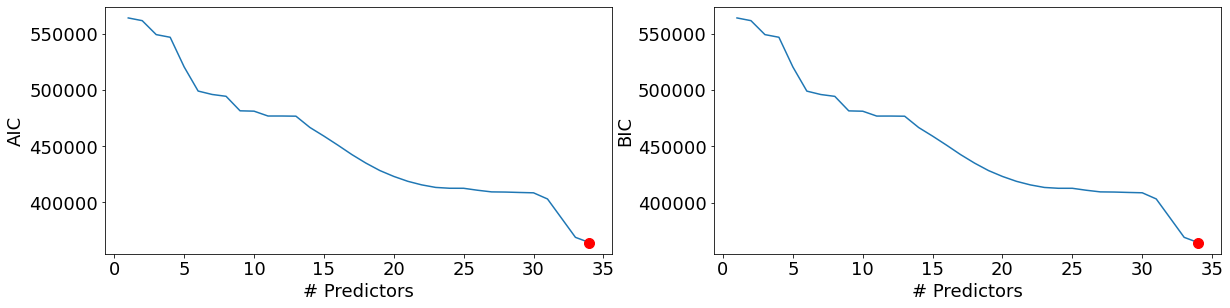

In [57]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    llr_pvalue = models_best.apply(lambda row: row[1].llr_pvalue, axis=1)

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 1)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [60]:
#Same as baseline model

Multicollinearity Analysis (VIF)

*by Candy Tantichirasakul*

In [58]:
X = train_smote[['BMI', 'Smoking', 'AlcoholDrinking', "Stroke", "Sex",'PhysicalHealth', "DiffWalking", "Diabetic", "PhysicalActivity", "SleepTime", "Asthma", "KidneyDisease", "SkinCancer"]]


In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

             feature        VIF
0              const  54.782921
1                BMI   1.113899
2            Smoking   1.035308
3    AlcoholDrinking   1.016687
4             Stroke   1.029939
5                Sex   1.039117
6     PhysicalHealth   1.343115
7        DiffWalking   1.377622
8           Diabetic   1.092440
9   PhysicalActivity   1.214120
10         SleepTime   1.012846
11            Asthma   1.027016
12     KidneyDisease   1.034961
13        SkinCancer   1.010989


Interactions

*by Candy Tantichirasakul*

In [83]:
#Interaction between Asthma and Smoking
model2 = sm.logit(formula = 'HeartDisease~AgeCategory+GenHealth+Asthma*Smoking+Diabetic+KidneyDisease+Stroke+Sex+AlcoholDrinking+DiffWalking+BMI+SkinCancer+MentalHealth+Race+SleepTime+PhysicalActivity+PhysicalHealth', data = train_smote).fit()



Optimization terminated successfully.
         Current function value: 0.444382
         Iterations 7


Classification accuracy = 81.3%
Precision = 23.9%
TPR or Recall = 54.0%
FNR = 46.0%
FPR = 16.1%
ROC-AUC = 78.7%


0         0.044971
1         0.431125
2         0.801097
3         0.647766
4         0.033621
            ...   
319790    0.680089
319791    0.056570
319792    0.150411
319793    0.072680
319794    0.606009
Length: 319795, dtype: float64

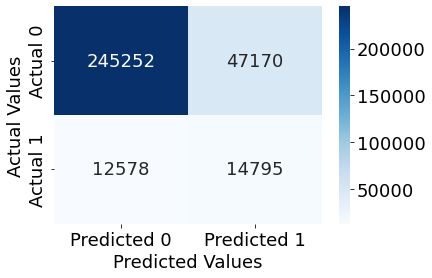

In [84]:
confusion_matrix_data(data,data.HeartDisease,model2,0.6)

In [85]:
#Interaction between Diabetic and Kidney
model3 = sm.logit(formula = 'HeartDisease~AgeCategory+GenHealth+Asthma+Smoking+Diabetic*KidneyDisease+Stroke+Sex+AlcoholDrinking+DiffWalking+BMI+SkinCancer+MentalHealth+Race+SleepTime+PhysicalActivity+PhysicalHealth', data = train_smote).fit()


Optimization terminated successfully.
         Current function value: 0.444270
         Iterations 7


Classification accuracy = 81.3%
Precision = 23.9%
TPR or Recall = 54.1%
FNR = 45.9%
FPR = 16.1%
ROC-AUC = 78.7%


0         0.044135
1         0.432285
2         0.798342
3         0.649588
4         0.033682
            ...   
319790    0.676352
319791    0.056940
319792    0.151152
319793    0.072796
319794    0.607844
Length: 319795, dtype: float64

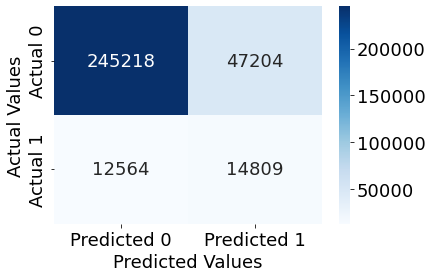

In [86]:
confusion_matrix_data(data,data.HeartDisease,model3,0.6)

In [87]:
#Interaction between both
model4 = sm.logit(formula = 'HeartDisease~AgeCategory+GenHealth+Asthma*Smoking+Diabetic*KidneyDisease+Stroke+Sex+AlcoholDrinking+DiffWalking+BMI+SkinCancer+MentalHealth+Race+SleepTime+PhysicalActivity+PhysicalHealth', data = train_smote).fit()


Optimization terminated successfully.
         Current function value: 0.444270
         Iterations 7


Classification accuracy = 81.3%
Precision = 23.9%
TPR or Recall = 54.1%
FNR = 45.9%
FPR = 16.1%
ROC-AUC = 78.7%


0         0.043928
1         0.432196
2         0.797531
3         0.649480
4         0.033674
            ...   
319790    0.675257
319791    0.056671
319792    0.151091
319793    0.072763
319794    0.607713
Length: 319795, dtype: float64

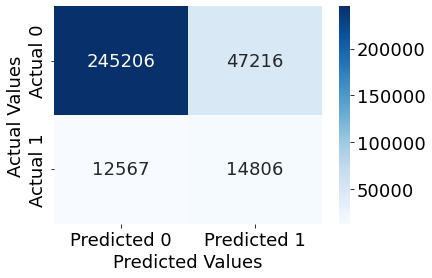

In [88]:
confusion_matrix_data(data,data.HeartDisease,model4,0.6)

In [89]:
#AgeCategory * GenHealth
model5 = sm.logit(formula = 'HeartDisease~AgeCategory*GenHealth+Asthma+Smoking+Diabetic+KidneyDisease+Stroke+Sex+AlcoholDrinking+DiffWalking+BMI+SkinCancer+MentalHealth+Race+SleepTime+PhysicalActivity+PhysicalHealth', data = train_smote).fit()


Optimization terminated successfully.
         Current function value: 0.441727
         Iterations 8


Classification accuracy = 80.6%
Precision = 23.2%
TPR or Recall = 54.8%
FNR = 45.2%
FPR = 17.0%
ROC-AUC = 78.8%


0         0.034741
1         0.485458
2         0.781655
3         0.646952
4         0.026793
            ...   
319790    0.687399
319791    0.046321
319792    0.144988
319793    0.068795
319794    0.605644
Length: 319795, dtype: float64

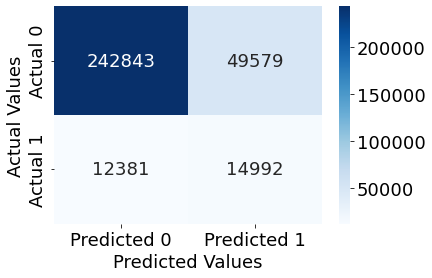

In [90]:
confusion_matrix_data(data,data.HeartDisease,model5,0.6)

In [91]:
model6 = sm.logit(formula = 'HeartDisease~AgeCategory+GenHealth+Asthma+Smoking+Diabetic+KidneyDisease+Sex+AlcoholDrinking+Stroke*DiffWalking+BMI+SkinCancer+MentalHealth+Race+SleepTime+PhysicalActivity+PhysicalHealth', data = train_smote).fit()


Optimization terminated successfully.
         Current function value: 0.444381
         Iterations 7


Classification accuracy = 81.3%
Precision = 23.9%
TPR or Recall = 54.1%
FNR = 45.9%
FPR = 16.1%
ROC-AUC = 78.7%


0         0.045190
1         0.426468
2         0.802066
3         0.648101
4         0.033514
            ...   
319790    0.680638
319791    0.056873
319792    0.150557
319793    0.072738
319794    0.606510
Length: 319795, dtype: float64

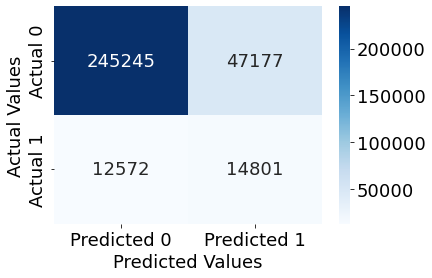

In [92]:
confusion_matrix_data(data,data.HeartDisease,model6,0.6)

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

Odds Analysis

*by Candy Tantichirasakul*

In [93]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               409390
Model:                          Logit   Df Residuals:                   409354
Method:                           MLE   Df Model:                           35
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                  0.3589
Time:                        16:00:00   Log-Likelihood:            -1.8193e+05
converged:                       True   LL-Null:                   -2.8377e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.9293      0.057    -51.167      0.000      -3.042      -2.817
AgeCategory[T.25-29]           0.2979      0.050      5.915      0.000       0.199       0.397
AgeCategory[T.30-34]           0.6011      0.047     12.896      0.000       0.510       0.692
AgeCategory[T.35-39]           0.8569      0.044     19.453      0.000       0.771       0.943
AgeCategory[T.40-44]           1.2022      0.042     28.594      0.000       1.120       1.285
AgeCategory[T.45-49]           1.5427      0.041     37.921      0.000       1.463       1.622
AgeCategory[T.50-54]           1.9871      0.039     50.655      0.000       1.910       2.064
AgeCategory[T.55-59]           2.3104      0.039     60.007      0.000       2.235       2.386
AgeCategory[T.60-64]           2.6257      0.038     68.923      0.000       2.551       2.700
AgeCategory[T.65-69]           2.9110      0.038     76.585      0.000       2.837       2.986
AgeCategory[T.70-74]           3.2515      0.038     85.209      0.000       3.177       3.326
AgeCategory[T.75-79]           3.5531      0.039     91.574      0.000       3.477       3.629
AgeCategory[T.80 or older]     3.6044      0.039     92.838      0.000       3.528       3.680
Race[T.Asian]                 -0.8495      0.046    -18.556      0.000      -0.939      -0.760
Race[T.Black]                 -1.3654      0.037    -37.240      0.000      -1.437      -1.294
Race[T.Hispanic]              -0.5061      0.035    -14.620      0.000      -0.574      -0.438
Race[T.Other]                 -0.9137      0.041    -22.124      0.000      -0.995      -0.833
Race[T.White]                 -0.1412      0.031     -4.545      0.000      -0.202      -0.080
GenHealth[T.Fair]              3.1064      0.020    156.401      0.000       3.067       3.145
GenHealth[T.Good]              2.0901      0.017    122.426      0.000       2.057       2.124
GenHealth[T.Poor]              4.0816      0.028    147.792      0.000       4.027       4.136
GenHealth[T.Very good]         1.1017      0.017     64.206      0.000       1.068       1.135
BMI                            0.0073      0.001     10.372      0.000       0.006       0.009
Smoking                       -0.1826      0.009    -21.419      0.000      -0.199      -0.166
AlcoholDrinking               -1.8634      0.030    -61.580      0.000      -1.923      -1.804
Stroke                         0.0755      0.021      3.640      0.000       0.035       0.116
PhysicalHealth                -0.0052      0.001     -8.601      0.000      -0.006      -0.004
MentalHealth                   0.0076      0.001     13.410      0.000       0.006       0.009
DiffWalking                   -0.4525      0.013    -35.581      0.000      -0.477      -0.428
Sex                           -1.3631      0.009   -153.837      0.000      -1.380      -1.346
Diabetic                      -0.2224      0.012    -19.322      0.000      -0.245      -0.200
PhysicalAct

In [94]:
model.params

Intercept                    -2.929345
AgeCategory[T.25-29]          0.297883
AgeCategory[T.30-34]          0.601051
AgeCategory[T.35-39]          0.856858
AgeCategory[T.40-44]          1.202206
AgeCategory[T.45-49]          1.542701
AgeCategory[T.50-54]          1.987124
AgeCategory[T.55-59]          2.310368
AgeCategory[T.60-64]          2.625708
AgeCategory[T.65-69]          2.911013
AgeCategory[T.70-74]          3.251452
AgeCategory[T.75-79]          3.553131
AgeCategory[T.80 or older]    3.604352
Race[T.Asian]                -0.849478
Race[T.Black]                -1.365372
Race[T.Hispanic]             -0.506106
Race[T.Other]                -0.913724
Race[T.White]                -0.141233
GenHealth[T.Fair]             3.106363
GenHealth[T.Good]             2.090090
GenHealth[T.Poor]             4.081593
GenHealth[T.Very good]        1.101697
BMI                           0.007293
Smoking                      -0.182582
AlcoholDrinking              -1.863359
Stroke                   

In [95]:
np.exp(model.params.SleepTime) - 1

-0.03072037098323077

In [96]:
np.exp(model.params.PhysicalActivity) - 1

-0.4257467838941744

# Random Unplaced Stuff

# Baseline Model

In [76]:
model = sm.logit(formula = 'HeartDisease~BMI+Smoking+AlcoholDrinking+Stroke+PhysicalHealth+MentalHealth+DiffWalking+Sex+AgeCategory+Race+Diabetic+PhysicalActivity+GenHealth+SleepTime+Asthma+KidneyDisease+SkinCancer', data = train_smote).fit()

Optimization terminated successfully.
         Current function value: 0.444383
         Iterations 7


In [77]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               409390
Model:                          Logit   Df Residuals:                   409354
Method:                           MLE   Df Model:                           35
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                  0.3589
Time:                        15:58:53   Log-Likelihood:            -1.8193e+05
converged:                       True   LL-Null:                   -2.8377e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.9293      0.057    -51.167      0.000      -3.042      -2.817
AgeCategory[T.25-29]           0.2979      0.050      5.915      0.000       0.199       0.397
AgeCategory[T.30-34]           0.6011      0.047     12.896      0.000       0.510       0.692
AgeCategory[T.35-39]           0.8569      0.044     19.453      0.000       0.771       0.943
AgeCategory[T.40-44]           1.2022      0.042     28.594      0.000       1.120       1.285
AgeCategory[T.45-49]           1.5427      0.041     37.921      0.000       1.463       1.622
AgeCategory[T.50-54]           1.9871      0.039     50.655      0.000       1.910       2.064
AgeCategory[T.55-59]           2.3104      0.039     60.007      0.000       2.235       2.386
AgeCategory[T.60-64]           2.6257      0.038     68.923      0.000       2.551       2.700
AgeCategory[T.65-69]           2.9110      0.038     76.585      0.000       2.837       2.986
AgeCategory[T.70-74]           3.2515      0.038     85.209      0.000       3.177       3.326
AgeCategory[T.75-79]           3.5531      0.039     91.574      0.000       3.477       3.629
AgeCategory[T.80 or older]     3.6044      0.039     92.838      0.000       3.528       3.680
Race[T.Asian]                 -0.8495      0.046    -18.556      0.000      -0.939      -0.760
Race[T.Black]                 -1.3654      0.037    -37.240      0.000      -1.437      -1.294
Race[T.Hispanic]              -0.5061      0.035    -14.620      0.000      -0.574      -0.438
Race[T.Other]                 -0.9137      0.041    -22.124      0.000      -0.995      -0.833
Race[T.White]                 -0.1412      0.031     -4.545      0.000      -0.202      -0.080
GenHealth[T.Fair]              3.1064      0.020    156.401      0.000       3.067       3.145
GenHealth[T.Good]              2.0901      0.017    122.426      0.000       2.057       2.124
GenHealth[T.Poor]              4.0816      0.028    147.792      0.000       4.027       4.136
GenHealth[T.Very good]         1.1017      0.017     64.206      0.000       1.068       1.135
BMI                            0.0073      0.001     10.372      0.000       0.006       0.009
Smoking                       -0.1826      0.009    -21.419      0.000      -0.199      -0.166
AlcoholDrinking               -1.8634      0.030    -61.580      0.000      -1.923      -1.804
Stroke                         0.0755      0.021      3.640      0.000       0.035       0.116
PhysicalHealth                -0.0052      0.001     -8.601      0.000      -0.006      -0.004
MentalHealth                   0.0076      0.001     13.410      0.000       0.006       0.009
DiffWalking                   -0.4525      0.013    -35.581      0.000      -0.477      -0.428
Sex                           -1.3631      0.009   -153.837      0.000      -1.380      -1.346
Diabetic                      -0.2224      0.012    -19.322      0.000      -0.245      -0.200
PhysicalAct

In [78]:
from sklearn.metrics import roc_curve, auc
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))
    return pred_values

Classification accuracy = 81.3%
Precision = 23.9%
TPR or Recall = 54.0%
FNR = 46.0%
FPR = 16.1%
ROC-AUC = 78.7%


0         0.045198
1         0.431221
2         0.801958
3         0.647883
4         0.033629
            ...   
319790    0.681259
319791    0.056859
319792    0.150476
319793    0.072715
319794    0.606151
Length: 319795, dtype: float64

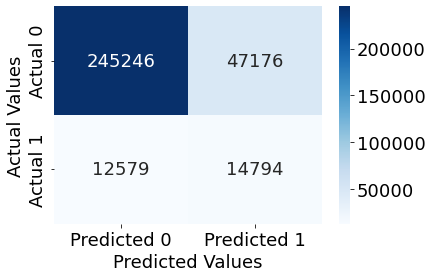

In [79]:
confusion_matrix_data(data,data.HeartDisease,model,0.6)

In [80]:
#Take out AlcoholDrinking + Race
model_reasoning = sm.logit(formula = 'HeartDisease~BMI+Smoking+Stroke+PhysicalHealth+MentalHealth+DiffWalking+Sex+AgeCategory+Diabetic+PhysicalActivity+GenHealth+SleepTime+Asthma+KidneyDisease+SkinCancer', data = train_smote).fit()
model_reasoning.summary()

Optimization terminated successfully.
         Current function value: 0.456371
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               409390
Model:                          Logit   Df Residuals:                   409360
Method:                           MLE   Df Model:                           29
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                  0.3416
Time:                        15:59:01   Log-Likelihood:            -1.8683e+05
converged:                       True   LL-Null:                   -2.8377e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.3551      0.048    -69.714      0.000      -3.449      -3.261
AgeCategory[T.25-29]           0.2841      0.050      5.689      0.000       0.186       0.382
AgeCategory[T.30-34]           0.5951      0.046     12.878      0.000       0.505       0.686
AgeCategory[T.35-39]           0.8648      0.044     19.814      0.000       0.779       0.950
AgeCategory[T.40-44]           1.2199      0.042     29.282      0.000       1.138       1.302
AgeCategory[T.45-49]           1.5715      0.040     38.982      0.000       1.492       1.650
AgeCategory[T.50-54]           2.0322      0.039     52.271      0.000       1.956       2.108
AgeCategory[T.55-59]           2.3793      0.038     62.365      0.000       2.305       2.454
AgeCategory[T.60-64]           2.7103      0.038     71.804      0.000       2.636       2.784
AgeCategory[T.65-69]           3.0145      0.038     80.044      0.000       2.941       3.088
AgeCategory[T.70-74]           3.3842      0.038     89.527      0.000       3.310       3.458
AgeCategory[T.75-79]           3.7034      0.038     96.342      0.000       3.628       3.779
AgeCategory[T.80 or older]     3.7747      0.038     98.162      0.000       3.699       3.850
GenHealth[T.Fair]              3.0587      0.020    156.397      0.000       3.020       3.097
GenHealth[T.Good]              2.0582      0.017    121.841      0.000       2.025       2.091
GenHealth[T.Poor]              4.0519      0.027    148.839      0.000       3.999       4.105
GenHealth[T.Very good]         1.1054      0.017     64.938      0.000       1.072       1.139
BMI                            0.0086      0.001     12.452      0.000       0.007       0.010
Smoking                       -0.1974      0.008    -23.669      0.000      -0.214      -0.181
Stroke                         0.0306      0.020      1.504      0.132      -0.009       0.070
PhysicalHealth                -0.0037      0.001     -6.218      0.000      -0.005      -0.003
MentalHealth                   0.0072      0.001     12.947      0.000       0.006       0.008
DiffWalking                   -0.4645      0.013    -37.161      0.000      -0.489      -0.440
Sex                           -1.3762      0.009   -157.704      0.000      -1.393      -1.359
Diabetic                      -0.2335      0.011    -20.636      0.000      -0.256      -0.211
PhysicalActivity              -0.5413      0.009    -57.235      0.000      -0.560      -0.523
SleepTime                     -0.0291      0.003    -10.321      0.000      -0.035      -0.024
Asthma                        -0.6711      0.014    -47.269      0.000      -0.699      -0.643
KidneyDisease                 -0.4820      0.021    -22.628      0.000      -0.524      -0.440
SkinCancer                    -0.5285      0.014    -38.358      0.000      -0.556      -0.501
==============================================================================================
"""

Classification accuracy = 80.9%
Precision = 23.6%
TPR or Recall = 55.0%
FNR = 45.0%
FPR = 16.6%
ROC-AUC = 79.2%


0         0.038515
1         0.403567
2         0.770654
3         0.630747
4         0.028105
            ...   
319790    0.707432
319791    0.063951
319792    0.166724
319793    0.079002
319794    0.674344
Length: 319795, dtype: float64

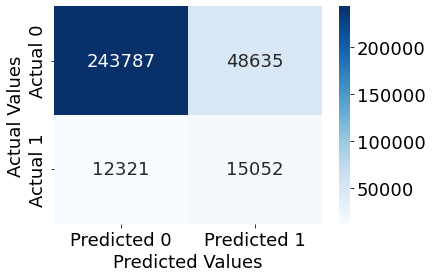

In [81]:
confusion_matrix_data(data,data.HeartDisease,model_reasoning,0.6)